IASD Data science Project: Attack of networks

# Import modules and data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4


train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Network to attack

In [ ]:
class Attackme(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 5)
    #self.conv3 = nn.Conv2d(64, 128, 5)
    self.fc1 = nn.Linear(64 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)    

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      #x = self.pool(F.relu(self.conv3(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

def training(model,epochs,device):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for ep in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{ep + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


train and test

In [ ]:
epochs = 5

model=Attackme()
model.to(device)
training(model,epochs,device)

tot = 0
ok = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        tot += labels.size(0)
        ok += (predicted == labels).sum().item()

print(f'Accu: {100 * ok // tot} %')



[1,  2000] loss: 1.850
[1,  4000] loss: 1.589
[1,  6000] loss: 1.495
[1,  8000] loss: 1.443
[1, 10000] loss: 1.400
[1, 12000] loss: 1.342
[2,  2000] loss: 1.287
[2,  4000] loss: 1.254
[2,  6000] loss: 1.267
[2,  8000] loss: 1.225
[2, 10000] loss: 1.206
[2, 12000] loss: 1.210
[3,  2000] loss: 1.138
[3,  4000] loss: 1.127
[3,  6000] loss: 1.124
[3,  8000] loss: 1.125
[3, 10000] loss: 1.130
[3, 12000] loss: 1.114
[4,  2000] loss: 1.026
[4,  4000] loss: 1.051
[4,  6000] loss: 1.054
[4,  8000] loss: 1.065
[4, 10000] loss: 1.034
[4, 12000] loss: 1.050
[5,  2000] loss: 0.998
[5,  4000] loss: 0.987
[5,  6000] loss: 0.996
[5,  8000] loss: 1.006
[5, 10000] loss: 0.997
[5, 12000] loss: 1.009
Accu: 63 %


save model

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Projet_A2/model_A3.pth' )

load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = Attackme()
model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Projet_A2/model_A3.pth'))
model.eval()

Attackme(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Atack mechanisms

FGSM

In [ ]:
from torch.autograd import Variable

class FGSM(object):
  def __init__(self, model, criterion,adv_training=False,plot_ex=False):
      self.model = model
      self.criterion = criterion
      self.adv_training = adv_training
      self.plot_ex = plot_ex

  def attack(self, x, y, eps, x_min=-1, x_max=1):

    x2 = Variable(x,requires_grad = True)

    output = self.model(x2)

    pred = output.max(1, keepdim=True)[1]
    
    cost = self.criterion(output,y)

    self.model.zero_grad()

    cost.backward()

    x_grad = x2.grad.data
  
    x_attacked = x + eps*(x_grad.sign())
    x_attacked = torch.clamp(x_attacked,x_min,x_max)

    if self.adv_training:
      return x_attacked
    elif self.plot_ex:
      y_attacked = self.model(x_attacked)
      return x_attacked,y_attacked
    else:
      y_attacked = self.model(x_attacked)
      return y_attacked


In [ ]:
fgsm = FGSM(model, nn.CrossEntropyLoss())
eps = 0.3


tot = 0
ok = 0

for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  y_attacked = fgsm.attack(images,labels,eps)
  predicted = y_attacked.max(1, keepdim=True)[1]
  tot += len(labels)
  ok += (predicted.T[0] == labels).sum().item()


print(f'Accu: {100 * ok / tot} %')

Accu: 2.37 %


study on epsilon

PGD Attack

In [ ]:
class PGD(object):
  def __init__(self, model, criterion,adv_training=False,plot_ex=False):
      self.model = model
      self.criterion = criterion
      self.adv_training = adv_training
      self.plot_ex = plot_ex

  def attack(self, x, y, eps, r=0.3, x_min=-1, x_max=1,iters=30):

    x0 = x
    
    for i in range(iters):
      x = Variable(x,requires_grad = True)
      output = self.model(x)
      pred = output.max(1, keepdim=True)[1]
      cost = self.criterion(output,y)
      self.model.zero_grad()
      cost.backward()
      x_grad = x.grad.data
      x = x + eps*(x_grad.sign())
      eta = torch.clamp(x-x0,min=-r,max=r)
      x = torch.clamp(x0+eta,x_min,x_max)

    if self.adv_training:
      return x
    elif self.plot_ex:
      y_attacked = self.model(x)
      return x,y_attacked
    else:
      y_attacked = self.model(x)
      return y_attacked

In [ ]:
pgd = PGD(model, nn.CrossEntropyLoss())
eps = 0.001


tot = 0
ok = 0
i=0
for images, labels in tqdm(test_loader):
  images, labels = images.to(device), labels.to(device)
  y_attacked = pgd.attack(images,labels,eps)
  predicted = y_attacked.max(1, keepdim=True)[1]
  tot += len(labels)
  ok += (predicted.T[0] == labels).sum().item()
  i += 1

print(f'Accu: {100 * ok / tot} %')

In [ ]:
fgsm = FGSM(model, nn.CrossEntropyLoss())
pgd = PGD(model, nn.CrossEntropyLoss())
Eps = np.linspace(0,1,15)

l_eps,l_acc_fgsm,l_acc_pgd = [],[],[]

for eps in tqdm(Eps):
  tot = 0
  ok = 0
  ok2 = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    y_attacked = fgsm.attack(images,labels,eps)
    predicted = y_attacked.max(1, keepdim=True)[1]
    tot += len(labels)
    ok += (predicted.T[0] == labels).sum().item()

    y_attacked = pgd.attack(images,labels,eps)
    predicted = y_attacked.max(1, keepdim=True)[1]
    ok2 += (predicted.T[0] == labels).sum().item()


  l_eps.append(eps)
  l_acc_fgsm.append(100 * ok / tot)
  l_acc_pgd.append(100 * ok2 / tot)

plt.figure(1)
plt.plot(l_eps,l_acc_fgsm,label='fgsm')
plt.plot(l_eps,l_acc_pgd,label='pgd')
plt.grid()
plt.legend()
plt.xlabel('epsilon')
plt.ylabel('accuracy (%)')
plt.show()


plot examples

In [ ]:
def plot_ex(attack,n_ex=4,l_eps=[0,0.005,0.5]):

  if attack == 'fgsm':
    att = FGSM(model, nn.CrossEntropyLoss(),plot_ex=True)
  else: 
    att = PGD(model, nn.CrossEntropyLoss(),plot_ex=True)

  plt.figure(figsize=(8,6))
 
  c=0
  
  
  for eps in l_eps:
    ite =0

    for images, labels in test_loader:
      ite+=1


      if ite ==4:
        images, labels = images.to(device), labels.to(device)
        x_attacked,y_attacked = att.attack(images,labels,eps)
        #x_attacked,y_attacked = images, model(images)
        x_attacked,y_attacked = x_attacked.squeeze().detach().cpu().numpy(),y_attacked.squeeze().detach().cpu()
        conf = F.softmax(y_attacked, dim=1)
        conf = torch.max(conf.data, 1)[0][0]
        predicted = y_attacked.max(1, keepdim=True)[1]
        for i in range(len(x_attacked.data)):
          c+=1
          x_att = x_attacked[i]
          plt.subplot(len(l_eps),n_ex,c)
          plt.xticks([], [])
          plt.yticks([], [])  
          #if eps == l_eps[0]:
          plt.ylabel("Eps: {}".format(eps), fontsize=14)
          plt.title("{} conf:{}%".format(classes[predicted[i]],round(float(conf)*100,2)))
          plt.imshow(x_att[0,:,:])

        break

  plt.tight_layout()
  plt.show()
  


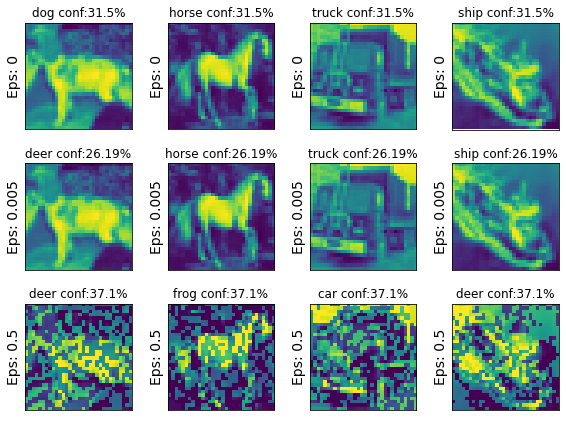

In [ ]:
plot_ex('fgsm')

## Adversarial Training

naive defense

In [ ]:

def naive_def_training(model,epochs, device, eps=0.05,train_fgsm=True, train_pgd=False,train_clean=True):
  fgsm = FGSM(model, nn.CrossEntropyLoss(),adv_training=True)
  pgd = PGD(model, nn.CrossEntropyLoss(),adv_training=True)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for ep in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        # FGSM Attack
        if train_fgsm:
          optimizer.zero_grad()
          x_attacked = fgsm.attack(images,labels,eps)
          outputs = model(x_attacked)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

        # PGD Attack
        if train_pgd:
          optimizer.zero_grad()
          x_attacked = pgd.attack(images,labels,eps)
          outputs = model(x_attacked)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

        if train_clean:        
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{ep + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

In [ ]:
def adv_training(model,epochs, device, eps=0.05, alpha=0.5, train_fgsm=True, train_pgd=False):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for ep in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        # FGSM Attack
        if train_fgsm:
          optimizer.zero_grad()
          outputs = model(labels)
          loss = alpha*criterion(outputs, labels)+(1-alpha)*criterion(outputs,)
          loss.backward()
          optimizer.step()

        # PGD Attack
        if train_pgd:

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{ep + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

IndentationError: ignored

test

In [ ]:
epochs = 10

adv_training(model,epochs,device,train_clean=False)


tot = 0
ok = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        tot += labels.size(0)
        ok += (predicted == labels).sum().item()

print(f'Accuracy without attack: {100 * ok // tot} %')

In [ ]:

fgsm = FGSM(model, nn.CrossEntropyLoss())
pgd = PGD(model, nn.CrossEntropyLoss())


eps = 0.05
tot = 0
ok = 0
ok2 = 0

for images, labels in tqdm(test_loader):
  images, labels = images.to(device), labels.to(device)

  y_attacked = fgsm.attack(images,labels,eps)
  predicted = y_attacked.max(1, keepdim=True)[1]
  tot += len(labels)
  ok += (predicted.T[0] == labels).sum().item()

  y_attacked = pgd.attack(images,labels,eps)
  predicted = y_attacked.max(1, keepdim=True)[1]
  ok2 += (predicted.T[0] == labels).sum().item()


print(f'Accuracy under FGSM attack: {100 * ok // tot} %')
print(f'Accuracy under PGD attack: {100 * ok2 // tot} %')




100%|██████████| 2500/2500 [02:32<00:00, 16.43it/s]

Accuracy under FGSM attack: 8 %
Accuracy under PGD attack: 3 %


test:

without adv training:
  base accuracy : 65%
  under FGSM attack: 9.64%
  under PGD attack: 0.00%

with adv training on FGSM:
  base accuracy : 63%
  under FGSM attack: %
  under PGD attack: %

with adv training on PGD:
  base accuracy : %
  under FGSM attack: %
  under PGD attack: %

with adv training on FGSM and PGD:
  base accuracy : %
  under FGSM attack: %
  under PGD attack: %



## Denoiser

DnCNN

In [ ]:
class Denoiser(nn.Module):
  def __init__(self,hid=10):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,padding=1,bias=False)
    hid_layers=[]
    for i in range(hid):
      hid_layers.append(nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1,bias=False))
      hid_layers.append(nn.BatchNorm2d(64))
      hid_layers.append(nn.ReLU(inplace=True))
    self.hidden_layers = nn.Sequential(*hid_layers)

    self.conv3 = nn.Conv2d(in_channels=64,out_channels=3,kernel_size=3,padding=1,bias=False)

  def forward(self, x):
      x = nn.ReLU(inplace=True)(self.conv1(x))
      x = self.hidden_layers(x)
      x = self.conv3(x)
      return x

def training_denoiser(model,epochs,device,noise_dataset):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for ep in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(noise_dataset, 0):

        clean, noisy = data[0][0].to(device), data[1][0].to(device)
        optimizer.zero_grad()

        outputs = model(clean)
        loss = criterion(outputs, noisy)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{ep + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

def training_denoiser2(model,epochs,device,att,eps=0.05):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for ep in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        x_attacked = att.attack(inputs,labels,eps)
        outputs = model(x_attacked)
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{ep + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


In [ ]:
class combined(nn.Module):
  def __init__(self,model,denoiser):
     super().__init__()
     self.model = model
     self.denoiser = denoiser

  def forward(self,x):
    x_clean=self.denoiser.forward(x)
    out = self.model.forward(x_clean)
    return out

In [ ]:
denoiser = Denoiser(hid=18)

train the denoiser

In [ ]:
denoiser.to(device)
att = PGD(model, nn.CrossEntropyLoss(),adv_training=True)
training_denoiser2(denoiser,10,device,att,eps=0.05)

[1,  2000] loss: 0.050
[1,  4000] loss: 0.032
[1,  6000] loss: 0.029
[1,  8000] loss: 0.024
[1, 10000] loss: 0.022
[1, 12000] loss: 0.019
[2,  2000] loss: 0.017
[2,  4000] loss: 0.015
[2,  6000] loss: 0.014
[2,  8000] loss: 0.014
[2, 10000] loss: 0.013
[2, 12000] loss: 0.012
[3,  2000] loss: 0.012
[3,  4000] loss: 0.011
[3,  6000] loss: 0.011
[3,  8000] loss: 0.011
[3, 10000] loss: 0.010
[3, 12000] loss: 0.010
[4,  2000] loss: 0.010
[4,  4000] loss: 0.010
[4,  6000] loss: 0.010
[4,  8000] loss: 0.009
[4, 10000] loss: 0.009
[4, 12000] loss: 0.009
[5,  2000] loss: 0.009
[5,  4000] loss: 0.009
[5,  6000] loss: 0.009
[5,  8000] loss: 0.009
[5, 10000] loss: 0.009
[5, 12000] loss: 0.008
[6,  2000] loss: 0.008
[6,  4000] loss: 0.008
[6,  6000] loss: 0.008
[6,  8000] loss: 0.008
[6, 10000] loss: 0.008
[6, 12000] loss: 0.008
[7,  2000] loss: 0.008
[7,  4000] loss: 0.008
[7,  6000] loss: 0.008
[7,  8000] loss: 0.008
[7, 10000] loss: 0.008
[7, 12000] loss: 0.007
[8,  2000] loss: 0.008
[8,  4000] 

In [ ]:
training_denoiser2(denoiser,5,device,att,eps=0.15)

KeyboardInterrupt: ignored

test the denoiser

In [ ]:
## combine the two CNNS
full_model = combined(model,denoiser)

In [ ]:
fgsm = PGD(full_model, nn.CrossEntropyLoss(),adv_training=True)
eps = 0.05


tot = 0
ok = 0

for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  x_attacked = fgsm.attack(images,labels,eps)
  #x_denoised = denoiser(x_attacked)
  y_pred = full_model(x_attacked)
  predicted = y_pred.max(1, keepdim=True)[1]
  tot += len(labels)
  ok += (predicted.T[0] == labels).sum().item()


print(f'Accu: {100 * ok / tot} %')

Accu: 7.96 %


In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Projet_A2/model_A3_denoiser_015.pth' )

test FGSM:
without denoiser: 9.96%

eps 0.05 10 epoch: 27.88%
eps 0.15
